In [1]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Define the list of attributes and table names
# Example of how to fetch data from multiple tables
# attributes = ["t1.attribute1", "t2.attribute2", "t3.attribute3", "t4.attribute4"] # Any attribute names that we want to fetch
# table_names = ["table1", "table2", "table3", "table4"]  # The table names that we want to join
# join_conditions = ["t1.id = t2.id", "t1.id = t3.id", "t1.id = t4.id"]  # The join conditions for the tables


# Example of how to fetch data from a single table
attributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch
table_names = ["teams"]  # The table names that we want to join
join_conditions = []  # The join conditions for the tables

# Removing the table names from attributes
cleaned_attributes = [attr.split('.')[1] for attr in attributes]

In [3]:
# Connect to the existing SQLite database
conn = sqlite3.connect('db/WNBA_cleared.db')

# Generate the select and join clauses dynamically
select_clause = ", ".join(attributes)
join_clause = f"{table_names[0]} t1"
for i in range(1, len(table_names)):
    join_clause += f" JOIN {table_names[i]} t{i+1} ON {join_conditions[i-1]}"

# Create the complete query string
query = f"SELECT {select_clause} FROM {join_clause}"

# Execute the query
cursor = conn.cursor()
cursor.execute(query)
rows = cursor.fetchall()

# Convert the fetched data to a pandas dataframe
df = pd.DataFrame(rows, columns=[attribute.split('.')[1] for attribute in attributes])

# Close the connection
conn.close()

In [4]:
target = 'playoff'  # The target attribute
seed = 42           # The random seed for the train-test split


# Remove later
df[target] = df[target].replace({'Y': 1, 'N': 0})

In [5]:
# Define the pipeline with different models
# The names of the models will be used to retrieve the model from the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))   # We can use any classifier here to test multiple models
                                                                # We can also use SVC or any other classifier here
                                                                # Maybe we should use a different seed from the split seed (using: seed=42)
])

In [6]:
# Accuracy -> bad with unbalanced data
# Precision -> good with unbalanced data (high precision means low false positives)
# Recall -> good with unbalanced data (high recall means low false negatives)
# F1 -> good with unbalanced data (high f1 means low false positives and false negatives)
# ROC AUC -> good with unbalanced data (high roc auc means low false positives and false negatives)
metrics =  {
    'accuracy' : accuracy_score,
    'precision' : precision_score,
    'recall' : recall_score,
    'f1' : f1_score,
    'roc_auc' : roc_auc_score
}

In [7]:
# Plot the evaluation metrics over the years
def plot_metrics_over_years(all_results, start, total_years):
    for m in all_results:
        if (m != 'accuracy'): continue
        plt.figure()
        years = list(range(start, total_years + 1))
        plt.plot(years, all_results[m], marker='o')
        plt.title(f'{m} over the years')
        plt.xlabel('Year')
        plt.ylabel(m)
        plt.show()

In [8]:
#Sliding window
def sliding_window_analysis(df, start, total_years, window_size, target, metrics, pipeline):
    results = dict()
    all_results = {m: [] for m in metrics.keys()}

    for i in range(total_years - window_size):
        # Split the data into train and test sets
        train = df[(df['year'] >= start + i) & (df['year'] < start + i + window_size)]
        test = df[df['year'] == start + i + window_size]

        x_train = train.drop(target, axis=1)
        y_train = train[target]
        x_test = test.drop(target, axis=1)
        y_test = test[target]

        # Fit the pipeline to the training data
        pipeline.fit(x_train, y_train)

        # Predict the test data
        y_pred = pipeline.predict(x_test)
        #print(classification_report(y_test, y_pred))

        # Store the results
        for m in metrics.keys():
            if m not in results:
                results[m] = []
            results[m] = metrics[m](y_test, y_pred)

        for m in metrics.keys():
            all_results[m].append(metrics[m](y_test, y_pred))
    return all_results

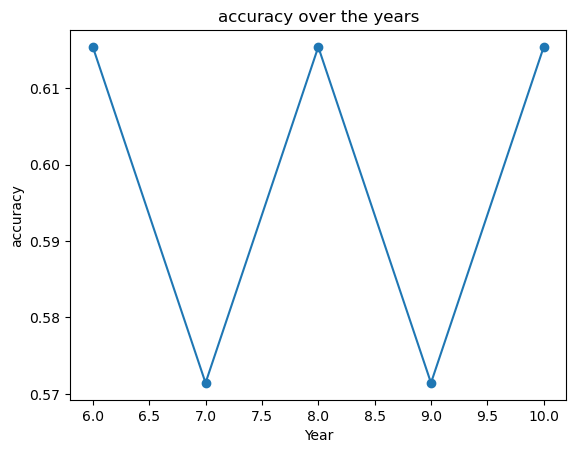

In [9]:
# Sliding window analysis
total_years = 10 # Total number of years that we have data for
window_size = 5 # Maybe test with different window sizes

start = 1
results = dict()
all_results = {m: [] for m in metrics.keys()}

all_results = sliding_window_analysis(df, start, total_years, window_size, target, metrics, pipeline)

plot_metrics_over_years(all_results, start + window_size, total_years)

In [10]:
# Expanding window
def expanding_window_analysis(df, start, total_years, target, metrics, pipeline):
    results = dict()
    all_results = {m: [] for m in metrics.keys()}

    for i in range(start, total_years + 1):
        # Split the data into train and test sets
        train = df[df['year'] < i]
        test = df[df['year'] == i]

        x_train = train.drop(target, axis=1)
        y_train = train[target]
        x_test = test.drop(target, axis=1)
        y_test = test[target]

        # Fit the pipeline to the training data
        pipeline.fit(x_train, y_train)

        # Predict the test data
        y_pred = pipeline.predict(x_test)
        #print(classification_report(y_test, y_pred))

        # Store the results
        for m in metrics.keys():
            if m not in results:
                results[m] = []
            results[m].append(metrics[m](y_test, y_pred))

        for m in metrics.keys():
            all_results[m].append(metrics[m](y_test, y_pred))
    return all_results


d:\Programas\CollegePrograms\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\CollegePrograms\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


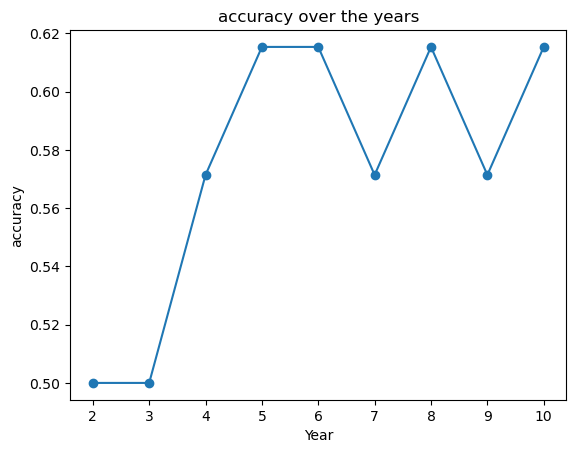

In [11]:
total_years = 10  # Total number of years that we have data for
start = 2 # Should be higher than 1 because we need to have at least 1 year of training data
results = dict()
all_results = {m: [] for m in metrics.keys()}

# Call the function with the appropriate arguments
all_results = expanding_window_analysis(df, start, total_years, target, metrics, pipeline)

plot_metrics_over_years(all_results, start, total_years)

In [12]:
# Mixed window
total_years = 10  # Total number of years that we have data for
start = 2  # Should be higher than 1 because we need to have at least 1 year of training data
start_sliding = 5  # Decide when to start sliding when predicting the 5th year

results = dict()
all_results = {m: [] for m in metrics.keys()}

for i in range(2, total_years + 1):
    # Expanding window
    if i < start_sliding:
        window_size = i + 1
        train = df[df['year'] < i]

    # Sliding window
    else:
        window_size = start_sliding
        train = df[(df['year'] >= i - window_size) & (df['year'] < i)]

    test = df[df['year'] == i]

    x_train = train.drop(target, axis=1)
    y_train = train[target]
    x_test = test.drop(target, axis=1)
    y_test = test[target]

    # Fit the pipeline to the training data
    pipeline.fit(x_train, y_train)

    # Predict the test data
    y_pred = pipeline.predict(x_test)
    #print(classification_report(y_test, y_pred))

    # Store the results
    for m in metrics.keys():
        if m not in results:
            results[m] = []
        results[m].append(metrics[m](y_test, y_pred))

    for m in metrics.keys():
        all_results[m].append(metrics[m](y_test, y_pred))

d:\Programas\CollegePrograms\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\CollegePrograms\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


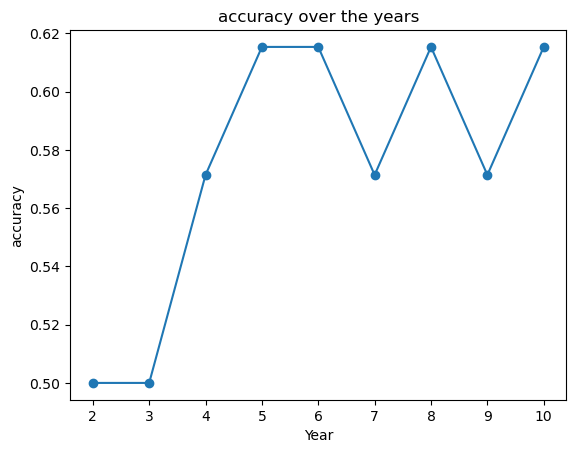

In [13]:
plot_metrics_over_years(all_results, start, total_years)

In [14]:
# Now we use the method pipeline.named_steps['scaler'] to retrieve data from the pipeline
# scaler_model = pipeline.named_steps['scaler']      # This will return the scaler object
# classifier_model = pipeline.named_steps['classifier']  # This will return the classifier object
# Use this to test n models and compare them later

In [15]:
# # Hyperparameter tuning example
# # Example for RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 5, 10, 20],
#     'classifier__min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search.fit(x, y)
# print("Best parameters:", grid_search.best_params_)
# 
# # Cross-validation example
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(pipeline, x, y, cv=5)
# print("Cross-validation scores:", scores)
# 
# # Testing the model on new data
# # Example using df_sixth_year as new data
# x_test = df_sixth_year.drop(columns=[target])
# y_test = df_sixth_year[target]
# y_pred_test = pipeline.predict(x_test)
# accuracy_test = accuracy_score(y_test, y_pred_test)
# print(f"Test Accuracy: {accuracy_test}")
# 

In [16]:
### TODO: Testing the model with the sixth year of data
### TODO: Evaluate the model using the sixth year of data
    ### TODO: Confusion matrix
    ### TODO: Accuracy and other metrics
    ### TODO: Store the data from this to compare withe the evolutions of the model
### TODO: Append the sixth year of data to the first five years of data
### TODO: Repeat the process for the seventh, eighth, ninth and tenth years of data